<a href="https://colab.research.google.com/github/yohanes-erwin/notebook/blob/main/rnn_sine_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%tensorflow_version 2.x
import tensorflow as tf

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Data Preprocessing

Membuat data set time series.

In [2]:
# Total sample point
N = 3000
# Sample point untuk membagi data train dan test
Tp = 750

In [3]:
t = np.arange(0, N)
x = (2*np.sin(0.02*t)*np.sin(0.003*t)) + 0.5*np.random.normal(size=N)
df = pd.DataFrame(x, columns=['Data'])

In [4]:
df.head()

,Data
0,0.933709
1,0.242867
2,0.424089
3,-0.235702
4,0.414714


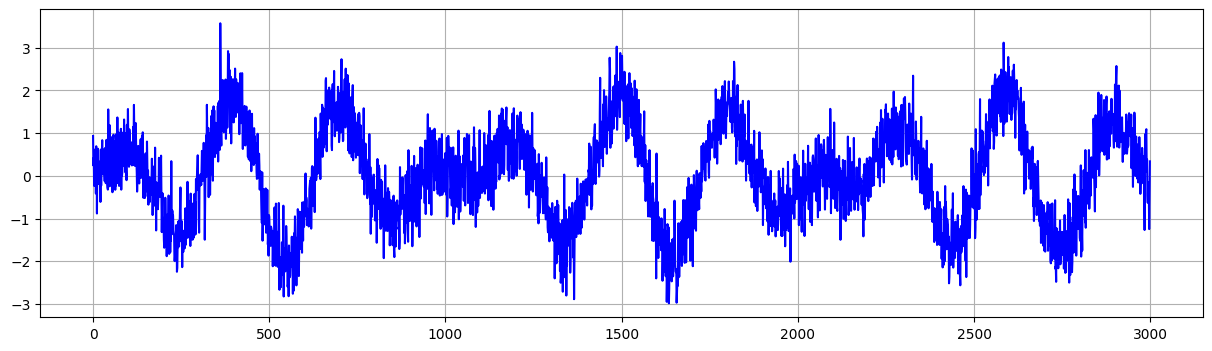

In [5]:
plt.figure(figsize=(15,4))
plt.plot(df, c='blue')
plt.grid(True)
plt.show()

Membagi data menjadi data training dan test.

In [6]:
values = df.values
train, test = values[0:Tp,:], values[Tp:N,:]

In [7]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (750, 1)
Test data length: (2250, 1)


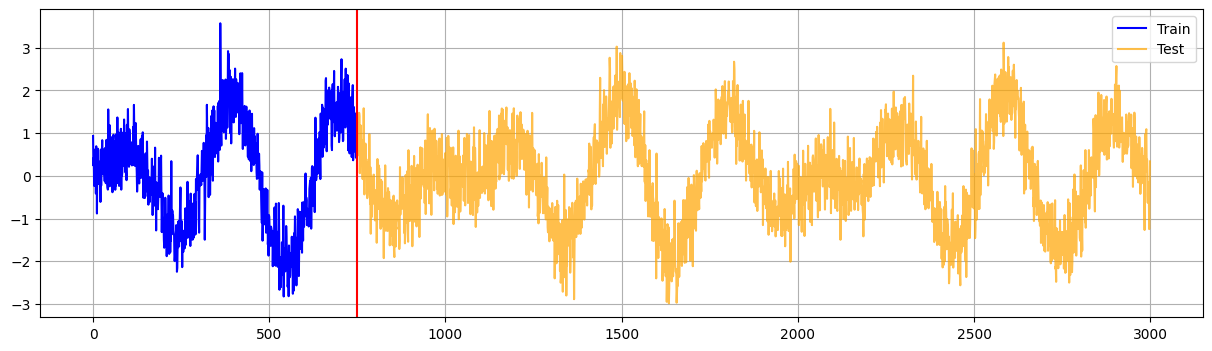

In [8]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.plot(index[0:Tp], train, c='blue')
plt.plot(index[Tp:N], test, c='orange', alpha=0.7)
plt.legend(['Train','Test'])
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.show()

Mengubah bentuk data menjadi step/embedding.

Jika x = {1,2,3,4,5,6,7,8,9,10}, untuk step=1, x (input) dan y (prediction) menjadi:

| x | y |
|---|---|
| 1 | 2 |
| 2 | 3 |
| 3 | 4 |
|...|...|
| 9 | 10|

Jika x = {1,2,3,4,5,6,7,8,9,10}, untuk step=3, x (input) dan y (prediction) menjadi:

|   x   | y |
|-------|---|
| 1,2,3 | 4 |
| 2,3,4 | 5 |
| 4,5,6 | 6 |
|  ...  |...|
| 7,8,9 | 10|

In [9]:
step = 4

In [10]:
# Menambahkan element step ke data train dan test
train = np.append(train, np.repeat(train[-1,], step))
test = np.append(test, np.repeat(test[-1,], step))

In [11]:
print("Train data length:", train.shape)
print("Test data length:", test.shape)

Train data length: (754,)
Test data length: (2254,)


In [12]:
def convertToMatrix(data, step):
  X, Y = [], []
  for i in range(len(data)-step):
    d = i + step
    X.append(data[i:d,])
    Y.append(data[d,])
  return np.array(X), np.array(Y)

In [13]:
trainX, trainY = convertToMatrix(train, step)
testX, testY = convertToMatrix(test, step)

In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [15]:
print("Training data shape:", trainX.shape, ', ', trainY.shape)
print("Test data shape:", testX.shape, ', ', testY.shape)

Training data shape: (750, 1, 4) ,  (750,)
Test data shape: (2250, 1, 4) ,  (2250,)


In [16]:
train[0:10]

array([ 0.93370886,  0.242867  ,  0.42408856, -0.23570167,  0.4147139 ,
        0.20203485,  0.61828368,  0.48637786, -0.41473625,  0.6935653 ])

In [17]:
trainX[0:5]

array([[[ 0.93370886,  0.242867  ,  0.42408856, -0.23570167]],

       [[ 0.242867  ,  0.42408856, -0.23570167,  0.4147139 ]],

       [[ 0.42408856, -0.23570167,  0.4147139 ,  0.20203485]],

       [[-0.23570167,  0.4147139 ,  0.20203485,  0.61828368]],

       [[ 0.4147139 ,  0.20203485,  0.61828368,  0.48637786]]])

In [18]:
trainY[0:5]

array([ 0.4147139 ,  0.20203485,  0.61828368,  0.48637786, -0.41473625])

### Recurrent Neural Network

Membuat model RNN.

In [19]:
num_units = 128
embedding = 4
num_dense = 32
lr = 0.001

In [20]:
model = tf.keras.models.Sequential()

In [21]:
model.add(tf.keras.layers.SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
model.add(tf.keras.layers.Dense(num_dense, activation="relu"))
model.add(tf.keras.layers.Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               17024     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21185 (82.75 KB)
Trainable params: 21185 (82.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=['mse'])

In [24]:
# Callback function training
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if (epoch+1)%50 == 0 and epoch > 0:
      print("Epoch number {} done".format(epoch+1))

In [25]:
batch_size = 16
num_epochs = 1000

In [26]:
# Training model
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, callbacks=[MyCallback()], verbose=0)

Epoch number 50 done
Epoch number 100 done
Epoch number 150 done
Epoch number 200 done
Epoch number 250 done
Epoch number 300 done
Epoch number 350 done
Epoch number 400 done
Epoch number 450 done
Epoch number 500 done
Epoch number 550 done
Epoch number 600 done
Epoch number 650 done
Epoch number 700 done
Epoch number 750 done
Epoch number 800 done
Epoch number 850 done
Epoch number 900 done
Epoch number 950 done
Epoch number 1000 done


Plot loss dari hasil training.

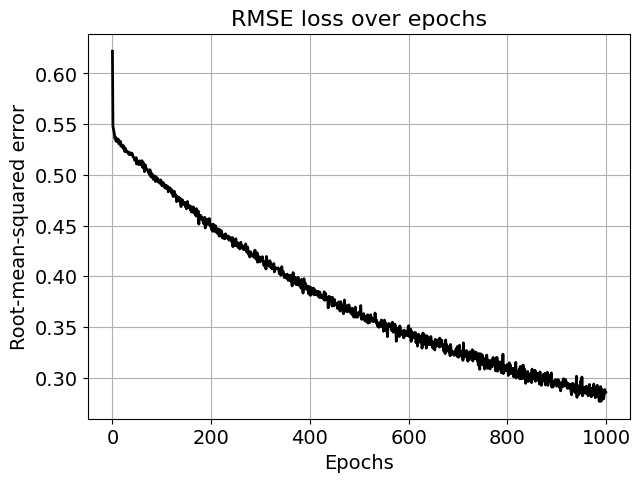

In [27]:
plt.figure(figsize=(7,5))
plt.title("RMSE loss over epochs", fontsize=16)
plt.plot(np.sqrt(model.history.history['loss']), c='k', lw=2)
plt.grid(True)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Root-mean-squared error", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Inference

Melakukan prediksi dengan model yang sudah di-training.

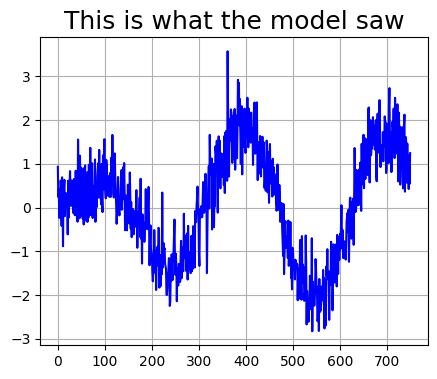

In [28]:
plt.figure(figsize=(5,4))
plt.title("This is what the model saw", fontsize=18)
plt.plot(trainX[:,0][:,0], c='blue')
plt.grid(True)
plt.show()

In [29]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
predicted = np.concatenate((trainPredict,testPredict), axis=0)

71/71 [==============================] - 0s 2ms/step


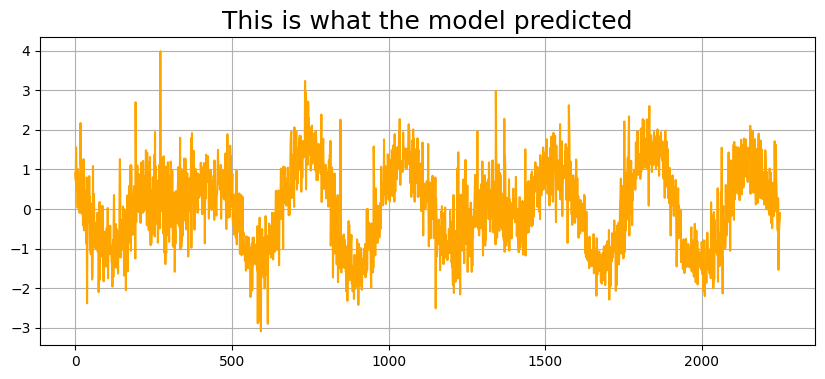

In [30]:
plt.figure(figsize=(10,4))
plt.title("This is what the model predicted", fontsize=18)
plt.plot(testPredict, c='orange')
plt.grid(True)
plt.show()

Membandingkan dengan ground truth.

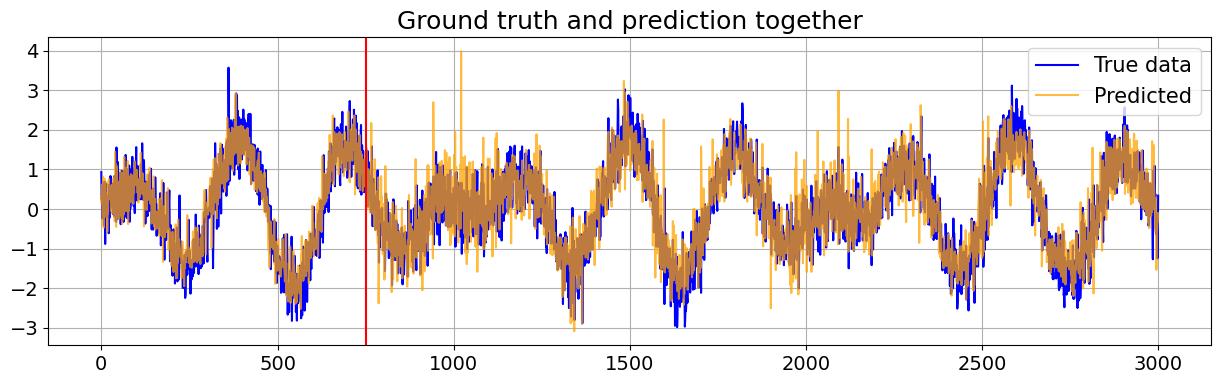

In [31]:
index = df.index.values
plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together", fontsize=18)
plt.plot(index, df, c='blue')
plt.plot(index, predicted, c='orange', alpha=0.75)
plt.legend(['True data','Predicted'], fontsize=15)
plt.axvline(df.index[Tp], c="r")
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

Menghitung error terhadap ground truth.

In [32]:
error = predicted[Tp:N] - df[Tp:N]
error = np.array(error).ravel()

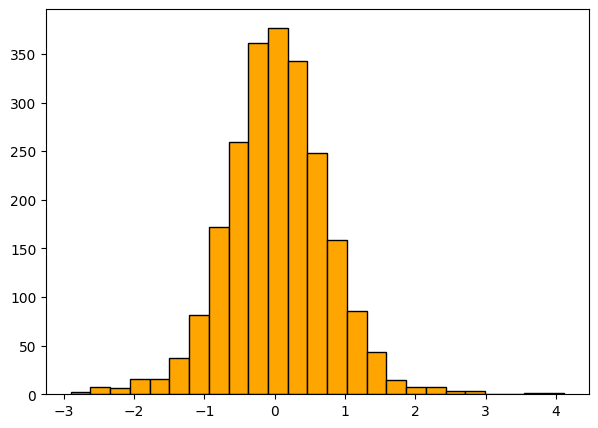

In [33]:
plt.figure(figsize=(7,5))
plt.hist(error,bins=25,edgecolor='k',color='orange')
plt.show()

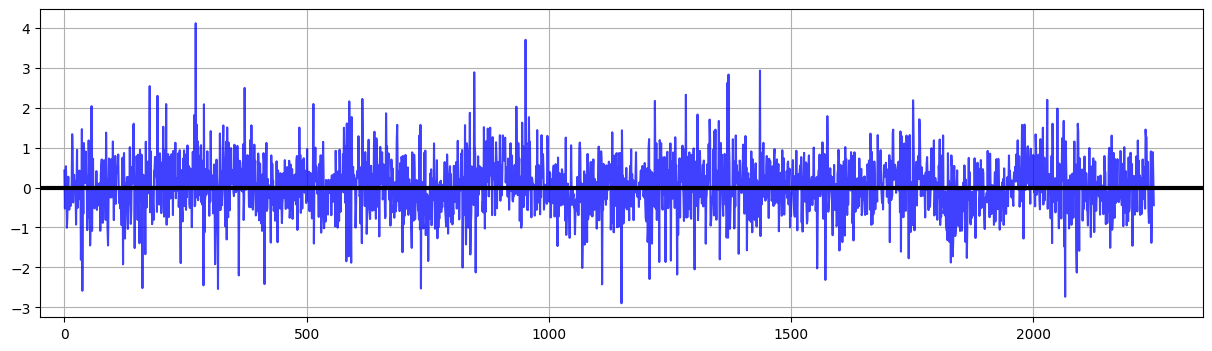

In [34]:
plt.figure(figsize=(15,4))
plt.plot(error, c='blue', alpha=0.75)
plt.hlines(y=0, xmin=-50, xmax=2400, color='k', lw=3)
plt.xlim(-50, 2350)
plt.grid(True)
plt.show()

### Improvement

Melakukan tuning hyperparameter (step/embedding size, epoch, dan batch size) untuk mendapatkan model yang optimal.

In [35]:
def prepare_data(step=4):
  values = df.values
  train, test = values[0:Tp,:], values[Tp:N,:]
  train = np.append(train, np.repeat(train[-1,], step))
  test = np.append(test, np.repeat(test[-1,], step))
  trainX, trainY = convertToMatrix(train, step)
  testX, testY = convertToMatrix(test, step)
  trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
  testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

  return trainX, testX, trainY, testY

In [36]:
def build_simple_rnn(num_units=128, embedding=4, num_dense=32, lr=0.001):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.SimpleRNN(units=num_units, input_shape=(1,embedding), activation="relu"))
  model.add(tf.keras.layers.Dense(num_dense, activation="relu"))
  model.add(tf.keras.layers.Dense(1))
  model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr), metrics=['mse'])

  return model

In [37]:
def predictions(model, trainX, testX):
  trainPredict = model.predict(trainX)
  testPredict = model.predict(testX)
  predicted = np.concatenate((trainPredict,testPredict), axis=0)

  return predicted

In [38]:
def plot_compare(predicted):
  index = df.index.values
  plt.figure(figsize=(15,4))
  plt.title("Ground truth and prediction together", fontsize=18)
  plt.plot(index, df, c='blue')
  plt.plot(index, predicted, c='orange', alpha=0.75)
  plt.legend(['True data','Predicted'], fontsize=15)
  plt.axvline(df.index[Tp], c="r")
  plt.grid(True)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

Memvariasikan step/embedding size.

71/71 [==============================] - 0s 2ms/step
Embedding size: 2
----------------------------------------------------------------------------------------------------


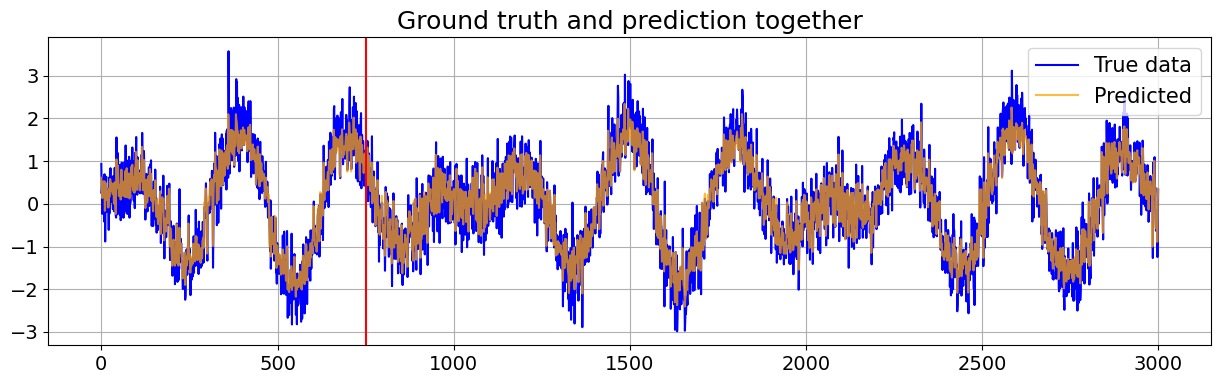


71/71 [==============================] - 0s 2ms/step
Embedding size: 4
----------------------------------------------------------------------------------------------------


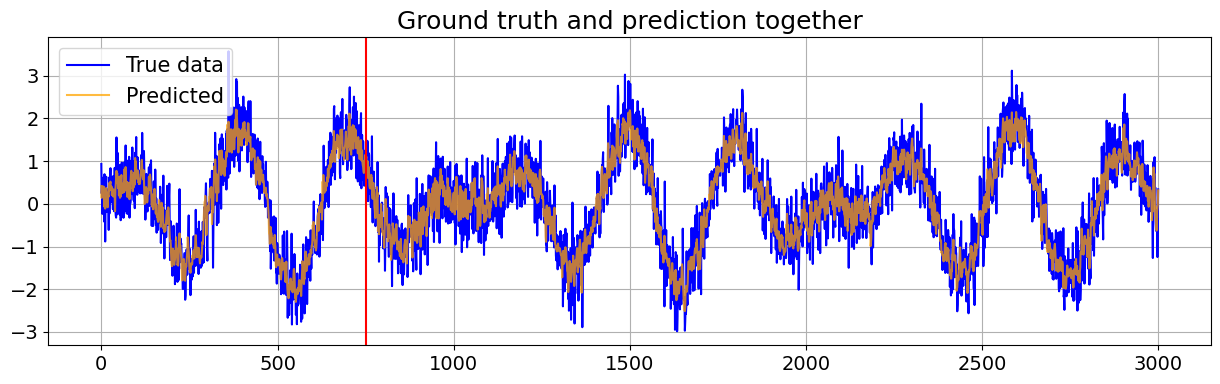


71/71 [==============================] - 0s 1ms/step
Embedding size: 6
----------------------------------------------------------------------------------------------------


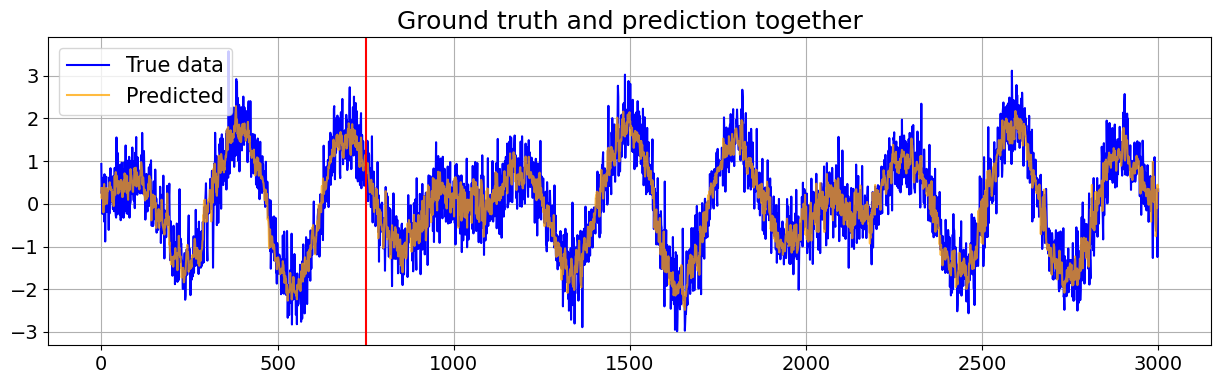


71/71 [==============================] - 0s 1ms/step
Embedding size: 8
----------------------------------------------------------------------------------------------------


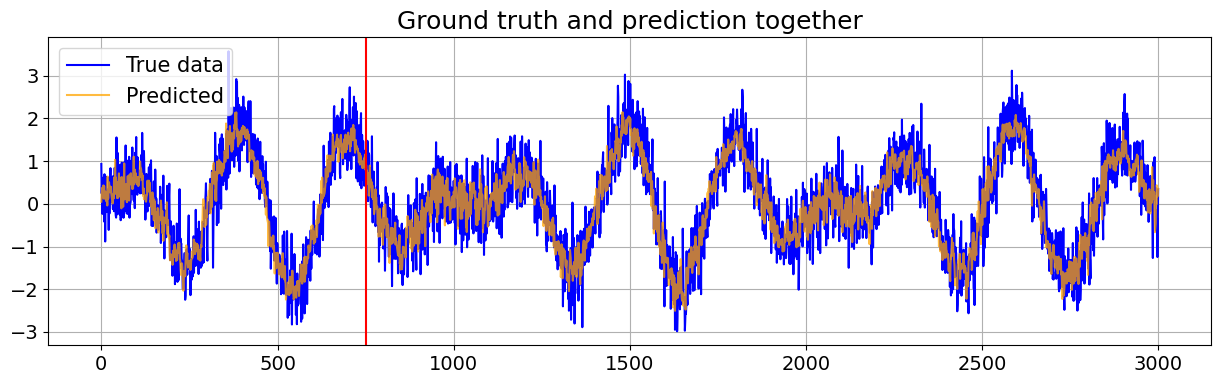


71/71 [==============================] - 0s 2ms/step
Embedding size: 10
----------------------------------------------------------------------------------------------------


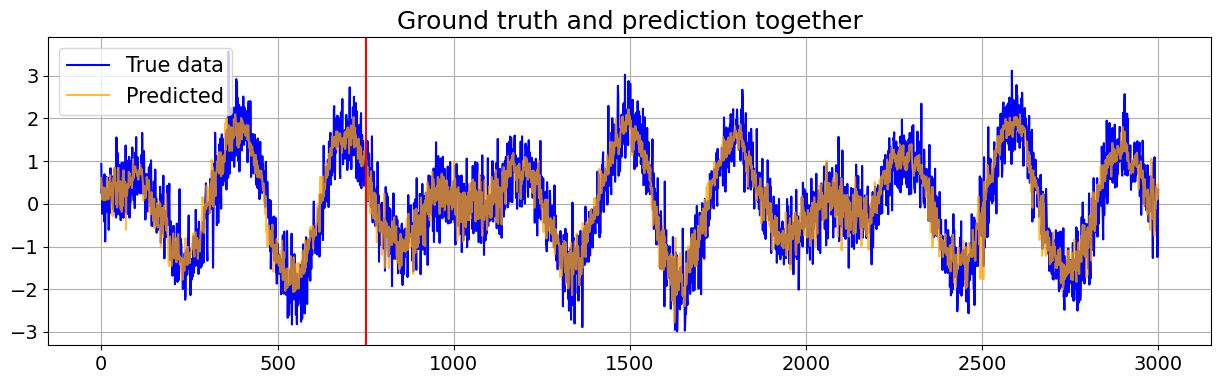


71/71 [==============================] - 0s 2ms/step
Embedding size: 12
----------------------------------------------------------------------------------------------------


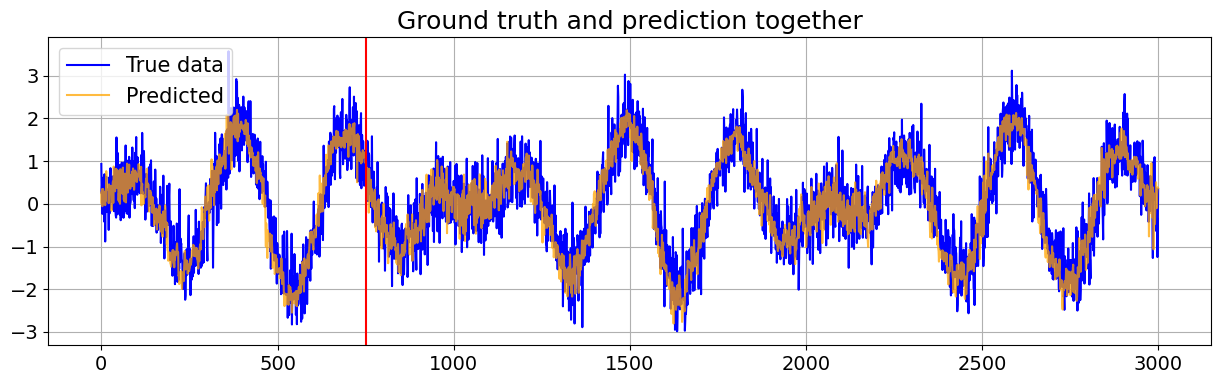

In [39]:
for s in [2,4,6,8,10,12]:
  trainX, testX, trainY, testY = prepare_data(s)
  model = build_simple_rnn(num_units=32, num_dense=8, embedding=s)
  batch_size = 16
  num_epochs = 100
  model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
  preds = predictions(model, trainX, testX)
  print("Embedding size: {}".format(s))
  print("-"*100)
  plot_compare(preds)
  print()

Memvariasikan jumlah epoch.

71/71 [==============================] - 0s 1ms/step
Ran for 100 epochs
----------------------------------------------------------------------------------------------------


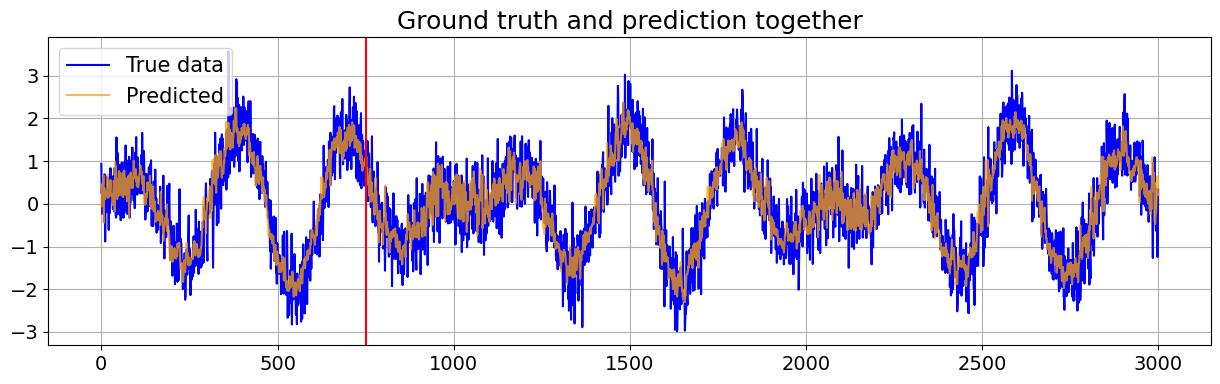


71/71 [==============================] - 0s 1ms/step
Ran for 200 epochs
----------------------------------------------------------------------------------------------------


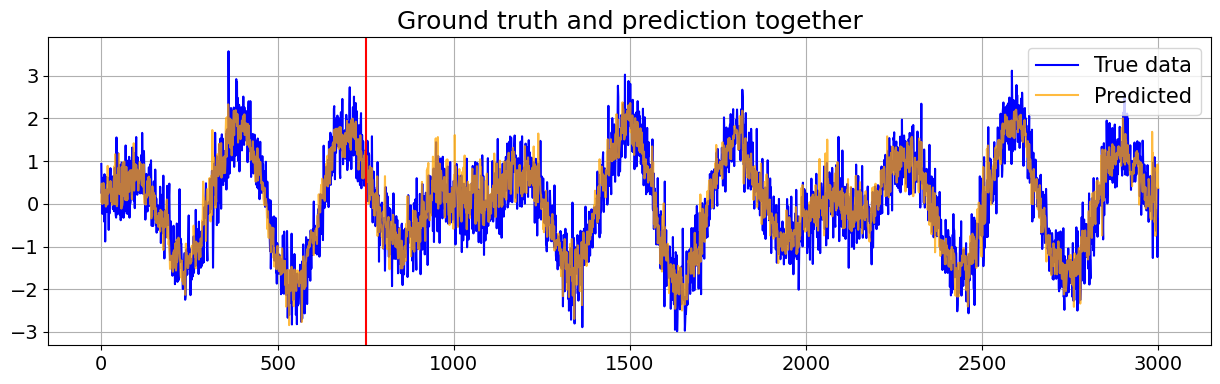


71/71 [==============================] - 0s 2ms/step
Ran for 300 epochs
----------------------------------------------------------------------------------------------------


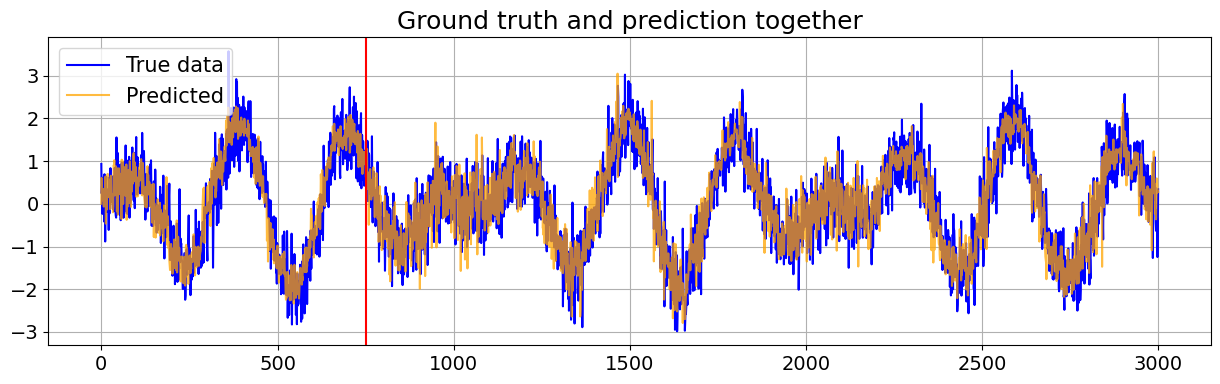


71/71 [==============================] - 0s 2ms/step
Ran for 400 epochs
----------------------------------------------------------------------------------------------------


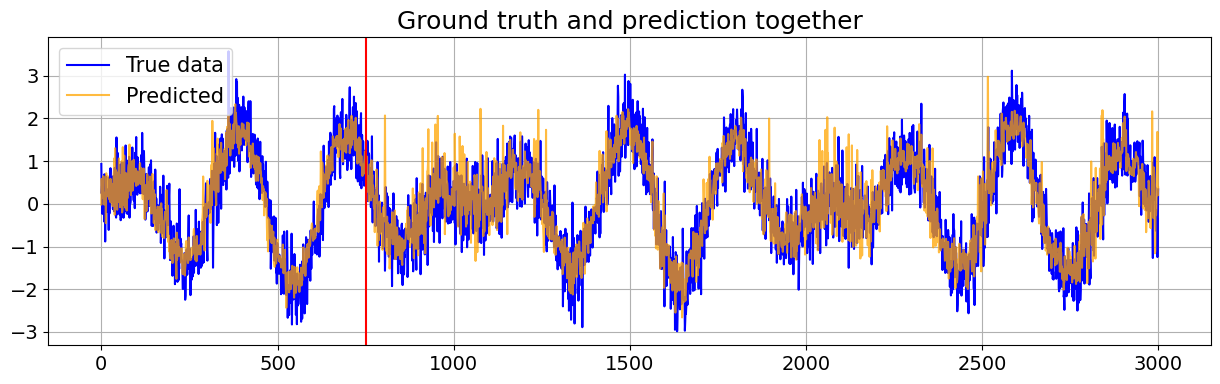


71/71 [==============================] - 0s 2ms/step
Ran for 500 epochs
----------------------------------------------------------------------------------------------------


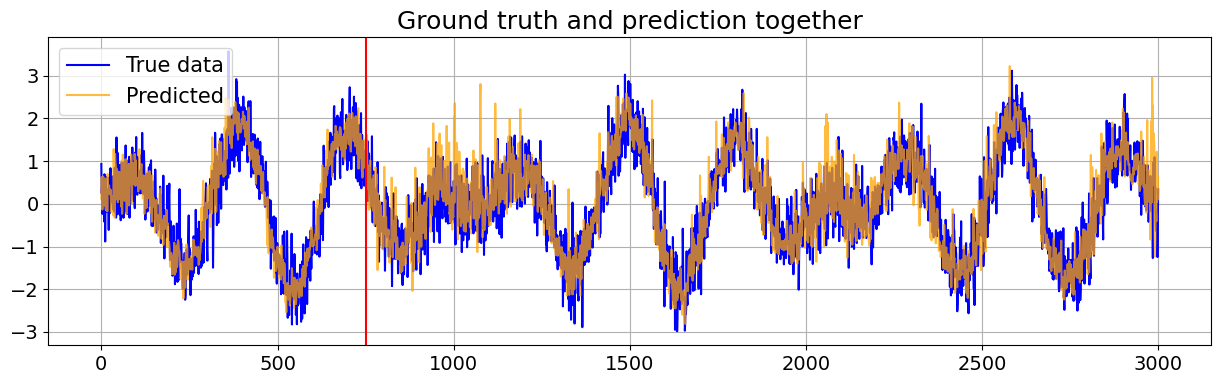

In [40]:
for e in [100,200,300,400,500]:
  trainX, testX, trainY, testY = prepare_data(8)
  model = build_simple_rnn(num_units=32, num_dense=8, embedding=8)
  batch_size = 16
  num_epochs = e
  model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
  preds = predictions(model, trainX, testX)
  print("Ran for {} epochs".format(e))
  print("-"*100)
  plot_compare(preds)
  print()

Memvariasikan batch size.

71/71 [==============================] - 0s 1ms/step
Ran with batch size: 4
----------------------------------------------------------------------------------------------------


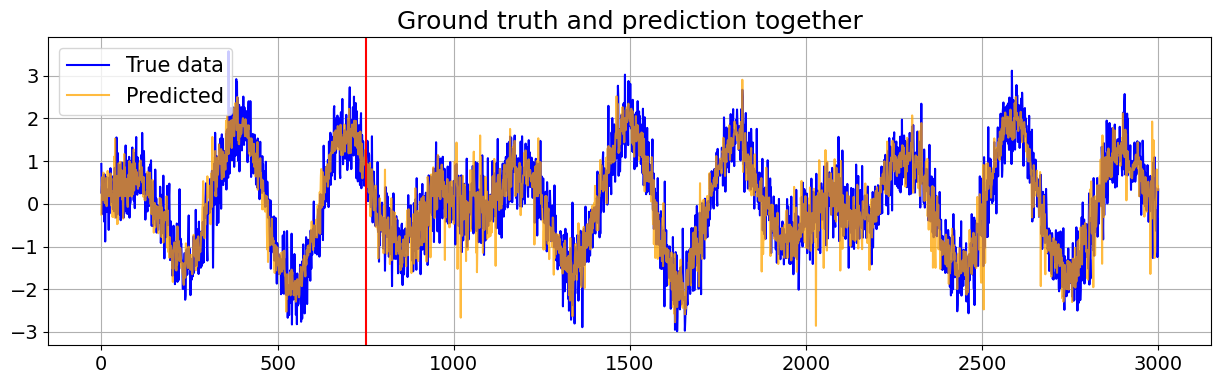


71/71 [==============================] - 0s 2ms/step
Ran with batch size: 8
----------------------------------------------------------------------------------------------------


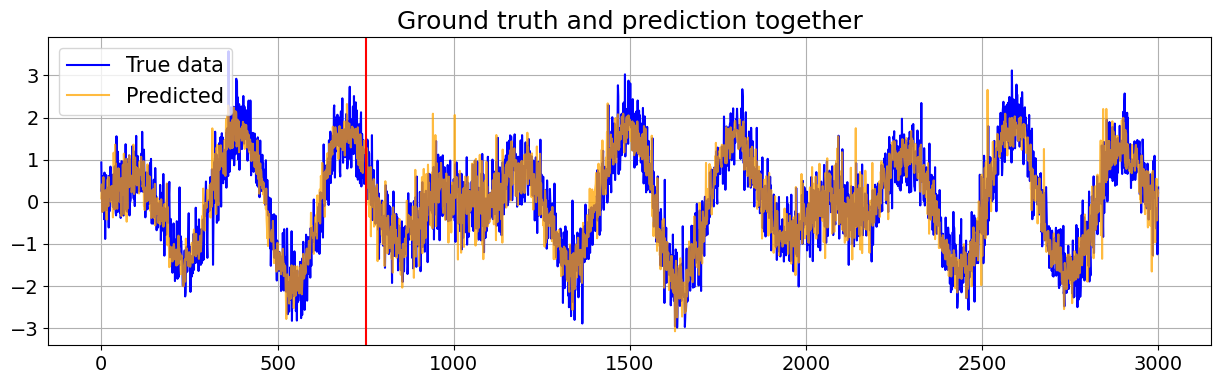


71/71 [==============================] - 0s 1ms/step
Ran with batch size: 16
----------------------------------------------------------------------------------------------------


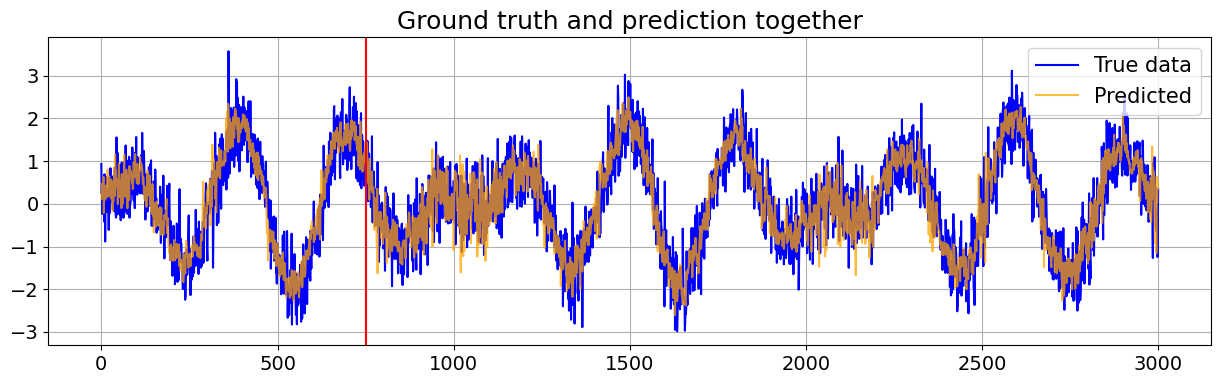


71/71 [==============================] - 0s 3ms/step
Ran with batch size: 32
----------------------------------------------------------------------------------------------------


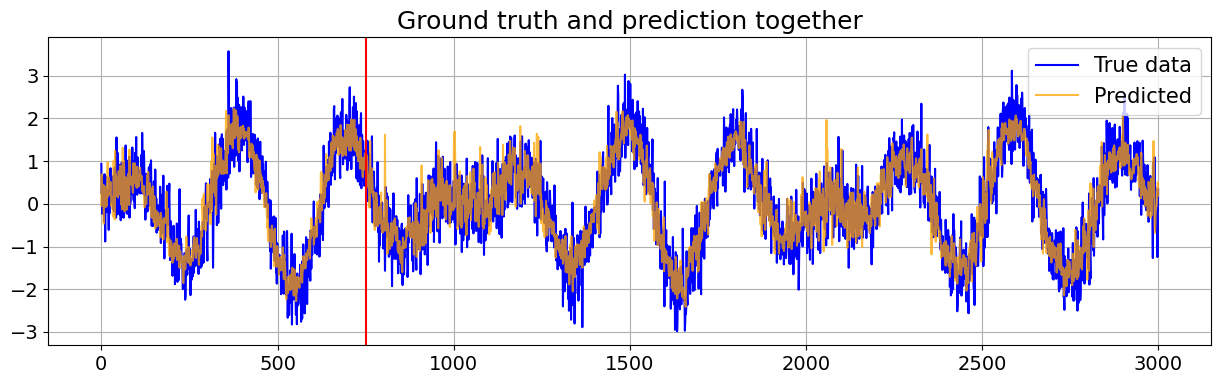


71/71 [==============================] - 0s 2ms/step
Ran with batch size: 64
----------------------------------------------------------------------------------------------------


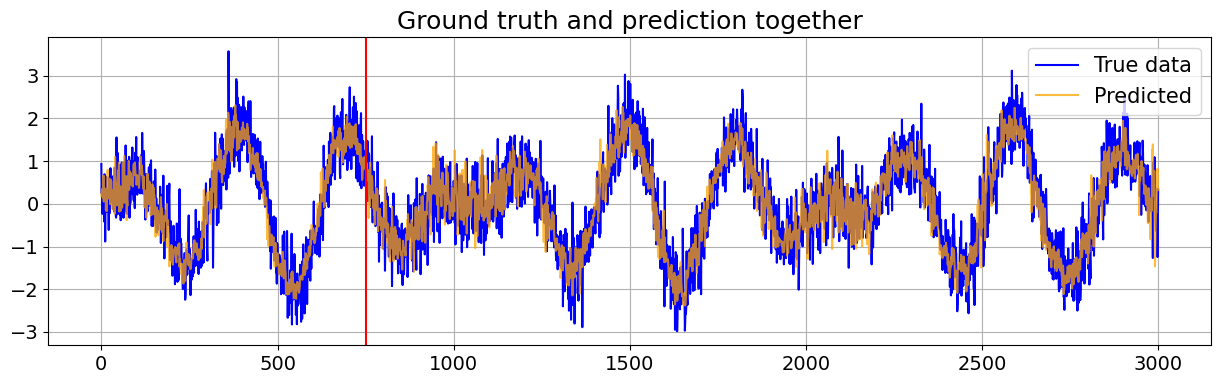

In [41]:
for b in [4,8,16,32,64]:
  trainX, testX, trainY, testY = prepare_data(8)
  model = build_simple_rnn(num_units=32, num_dense=8, embedding=8)
  batch_size = b
  num_epochs = 250
  model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=0)
  preds = predictions(model, trainX, testX)
  print("Ran with batch size: {}".format(b))
  print("-"*100)
  plot_compare(preds)
  print()

Dari hasil pengamatan, maka didapatkan hasil sebagai berikut:
- Embedding size yang terlalu kecil tidak berguna, tetapi jika terlalu besar tidak efektif. Embedding size 8 cukup baik untuk data ini.
- Epoch yang lebih banyak selalu lebih baik.
- Batch size 8 atau 16 terlihat optimal.